# Poisson Regression to predict menstrual cycle length with number of skipped periods

### By Mara Kaspers
##### 12/23/2021

In [ ]:
import numpy
from numpy import load
%matplotlib inline
%precision 16
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.stats import pearsonr
from scipy.stats import spearmanr

import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Introduction

Assessing the accuracy of fertility trackers in predicting menstrual cycles during clinical trials has proven to be difficult. The industry standard for assessing birth control efficacy is evaluation of the Pearl-Index, which takes into account the number of pregnancies, number of participants, and number of menstrual cycles. However, this method is not easily translatable to fertility trackers as both lifestyle interventions have different use cases, target populations, and leverage different physiologies. For example, compared to convential birth control methods, fertility trackers are not always used to prevent pregnancy and they don't physiologically prevent pregnancy. Since the emergence of at-home medical technology and digital health was rapid and recent, there is a lot of room for improvement in assessing accuracy of digitial fertililty tracking algorithms. Current clinical efficacy comparisons between fertility tracking devices are made by evaluation of the Pearl-Index and since this index was developed for birth control trials, there is a need for a more reliable accuracy metric to assess fertility trackers' clinical trials. 

Assessing the accuracy of fertility trackers is complicated as it demands consideration of multiple metrics from which many are convoluted with patient biases. For example, a leading company in the fertility tracking space published a clinical prediction accuracy of 99.4% in 2018 (REF1). However, this publication was recently retracted due to concerns about self reporting and selection bias (REF2). The retraction notice stated that the accuracy results were unreliable "due to selection bias and the retrospective self-reporting of whether pregnancies were intentional". Therefore, there is a need to improve clinical accuracy metrics and make the assessment methods of real-world accuracy more robust. 

In this research paper, I aim to investigate the effect of skipping menstrual cycles on menstrual cycle length variability using a Poisson's regression model. Since ovulation and individual fertility windows are predicted based on the user's ususal mentrual cycle length, variability in the cycle length can significantly affect the fertilty prediction's accuracy. In addition, skipping of menstrual cycles by use of oral birth control is common among fertility tracker users. Therefore, gaining more insight into the relation between skipping cycles and cycle variability per individual will be valuable in interpreting and improving current fertility tracker's clinical accuracy. Preprocessed data for this research was sourced from GitHub (REF3).

#### References
REF1 - Koch MC, Lermann J, van de Roemer N, et al. Improving usability and pregnancy rates of a fertility monitor by an additional mobile application: results of a retrospective efficacy study of Daysy and DaysyView app [retracted in: Reprod Health. 2019 May 14;16(1):54]. Reprod Health. 2018;15(1):37. Published 2018 Mar 2. doi:10.1186/s12978-018-0479-6

REF2 - Koch MC, Lermann J, van de Roemer N, et al. Retraction Note: Improving usability and pregnancy rates of a fertility monitor by an additional mobile application: results of a retrospective efficacy study of Daysy and DaysyView app [retraction of: Reprod Health. 2018 Mar 2;15(1):37]. Reprod Health. 2019;16(1):54. Published 2019 May 14. doi:10.1186/s12978-019-0728-3

REF3 - https://github.com/marakaspers/menstrual_cycle_analysis

# Problem Justification

The problem around fertility trackers' accuracy is of interest because non-hormonal birth control methods have become increasingly popular over the past decade. This increase in popularity coincides with the rapidly growing digital health market as investments in digital health solutions have been exponentially increasing over the past couple years. I suspect the popularity of fertility trackers to keep increasing as the market grows and as feminist movements around having ownership over, and insight into, one's health and reproductive choices keep moving forward.

# Computational  Methods



In this paper I aim to investigate the effect of skipping menstrual cycles on menstrual cycle variability using a Poisson's regression model. The metric of menstrual cycle variability used in this research is the cycle length difference (CLD). This metric is established in the field fertility data science (REF4) and is measured as the absolute difference between subsequent menstrual cycles in days. Since both CLD and number of skipped cycles will be processed as count data, the Poisson regression is most suitable in analyzing this problem. In this research I will implement the classic Poission regression model. The general form of the Poisson regression model is noted below.

Poisson's regression model function:
$$
P(y_i | x_i) = \frac{e^{- \lambda_i} \lambda_i^{y_i}}{y_i!}
$$

The exponential link function of the Poisson regression model:
$$
\lambda_i = e^{x_i\beta}
$$

#### References
REF4 - Li K, Urteaga I, Wiggins CH, et al. Characterizing physiological and symptomatic variation in menstrual cycles using self-tracked mobile-health data. NPJ Digit Med. 2020;3:79. Published 2020 May 26. doi:10.1038/s41746-020-0269-8

In [ ]:
# Provide complete installation or import information for external packages or modules here e.g.

#pip install somepackage
# from somepackage import blah

# Implementation

In [ ]:
# load data
data = load('cycle_lengths.npz', allow_pickle=True)
lst = data.files

#### Visually Explore the Raw Data

In [ ]:
# explore data
for item in lst:
    print("ITEM:", item)
    print("DATA:", data[item])

cycle_len = data[lst[4]]
print("cycle_len:", cycle_len[:10])

cycle_skip = data[lst[5]]
print("cycle_skip:", cycle_skip[:10])

true_params = data[lst[6]].tolist() # all parameters per person
print("true_params: length:{}\n\n lambda:{}\n\n xi:{}\n\n pi:{}".format(len(true_params['lambda'][:]), 
                true_params['lambda'][:10],
                true_params['xi'][:10],
                true_params['pi'][:10])) 

ITEM: data_model
DATA: generalized_poisson
ITEM: I
DATA: 5000
ITEM: C
DATA: 11
ITEM: hyperparameters
DATA: [160.   4.   2.  20.   1.  inf   2.  20.]
ITEM: cycle_lengths
DATA: [[19 23 24 ... 21 21 19]
 [21 23 22 ... 23 26 22]
 [28 50 30 ... 27 28 29]
 ...
 [20 21 21 ... 24 17 18]
 [23 24 20 ... 40 26 17]
 [19 16 35 ... 20 19 16]]
ITEM: cycle_skipped
DATA: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]]
ITEM: true_params
DATA: {'lambda': array([39.90658399893424 , 39.274639863802086, 39.62856606651357 , ...,
       36.931957935419895, 41.32193956782032 , 36.68849973126547 ]), 'xi': array([-0.8873923488561509, -0.855637703483654 , -0.4710213931324216, ...,
       -0.9002405724779966, -0.8640771762778565, -0.9382031695154998]), 'pi': array([0.0228252047295834, 0.0794450766549351, 0.1714968334904909, ...,
       0.1572070061561616, 0.0513795125371266, 0.1739272134737932])}
cycle_len: [[19 23 24 26 21 18 17 24 21 21 19]


5000
[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
35 [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 46 47 48 50 54 56]
35 [ 10  26  87 188 319 501 581 622 531 461 388 336 237 187 137 113  71  42
  33  48  20  21   9   8   4   5   4   3   1   2   1   1   1   1   1]


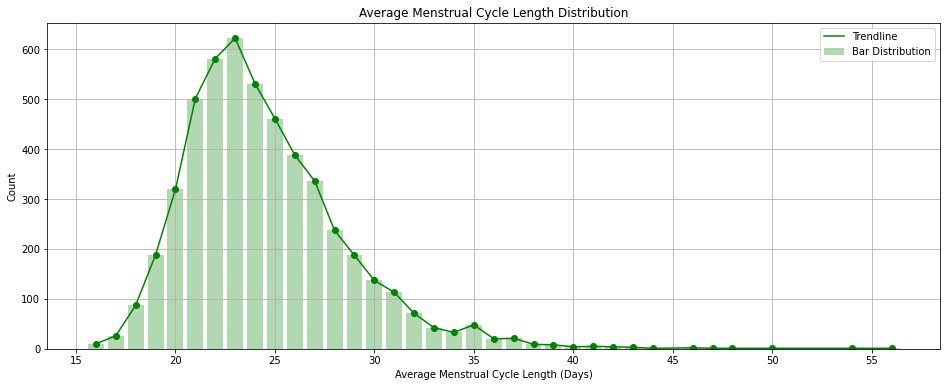

In [ ]:
# calculate mean cycle lengths
mean_cycle_len = []

for i in range(len(cycle_len)):
    mean_cycle_len.append(round(cycle_len[i].mean())) # rounded to full days

mean_cycle_len.sort()  # sort list
print(len(mean_cycle_len))
print(mean_cycle_len[:20])

# calculate probability of average cycle lengths
mean_cycle_len_vals = numpy.unique(mean_cycle_len, return_counts=True)[0]
mean_cycle_len_prob = numpy.unique(mean_cycle_len, return_counts=True)[1]
print(len(mean_cycle_len_vals), mean_cycle_len_vals)
print(len(mean_cycle_len_prob), mean_cycle_len_prob)

# plot mean menstrual cycle distribution
x = mean_cycle_len_vals
y = mean_cycle_len_prob

fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 1, 1)
axes.bar(x, y, color='g', alpha=.3, label='Bar Distribution')
axes.plot(x, y, 'g', label='Trendline')
axes.plot(x, y, 'go')
axes.set_title("Average Menstrual Cycle Length Distribution")
axes.set_xlabel("Average Menstrual Cycle Length (Days)")
axes.set_ylabel("Count")
axes.grid()

plt.legend()
plt.show()

CLD 2D Array: <class 'list'> 5000 [[4, 1, 2, 5, 3, 1, 7, 3, 0, 2], [2, 1, 0, 0, 7, 8, 3, 5, 3, 4], [22, 20, 6, 25, 27, 7, 2, 0, 1, 1], [5, 5, 6, 9, 8, 1, 3, 1, 0, 7], [27, 9, 21, 9, 35, 24, 18, 2, 2, 2], [0, 2, 1, 3, 1, 5, 5, 0, 1, 0], [22, 23, 23, 0, 4, 5, 3, 3, 3, 1], [2, 5, 0, 3, 0, 1, 1, 2, 1, 1], [19, 3, 2, 1, 6, 5, 6, 0, 4, 3], [2, 27, 7, 15, 21, 23, 4, 1, 25, 22], [48, 13, 33, 3, 32, 33, 3, 4, 4, 1], [30, 6, 3, 1, 5, 5, 0, 1, 0, 3], [4, 3, 2, 2, 8, 5, 1, 2, 3, 2], [28, 22, 3, 0, 0, 2, 6, 12, 2, 9], [5, 0, 4, 0, 0, 0, 0, 2, 0, 7], [48, 45, 3, 2, 2, 1, 5, 2, 17, 15], [4, 0, 0, 0, 20, 20, 0, 0, 23, 25], [0, 2, 6, 4, 4, 2, 2, 1, 3, 1], [1, 2, 2, 3, 4, 10, 2, 2, 4, 6], [3, 3, 2, 2, 7, 9, 5, 6, 3, 4]]
Mean CLD 1D Array: <class 'list'> 5000 [3, 3, 11, 4, 15, 2, 9, 2, 5, 15, 17, 5, 3, 8, 2, 14, 9, 2, 4, 4]


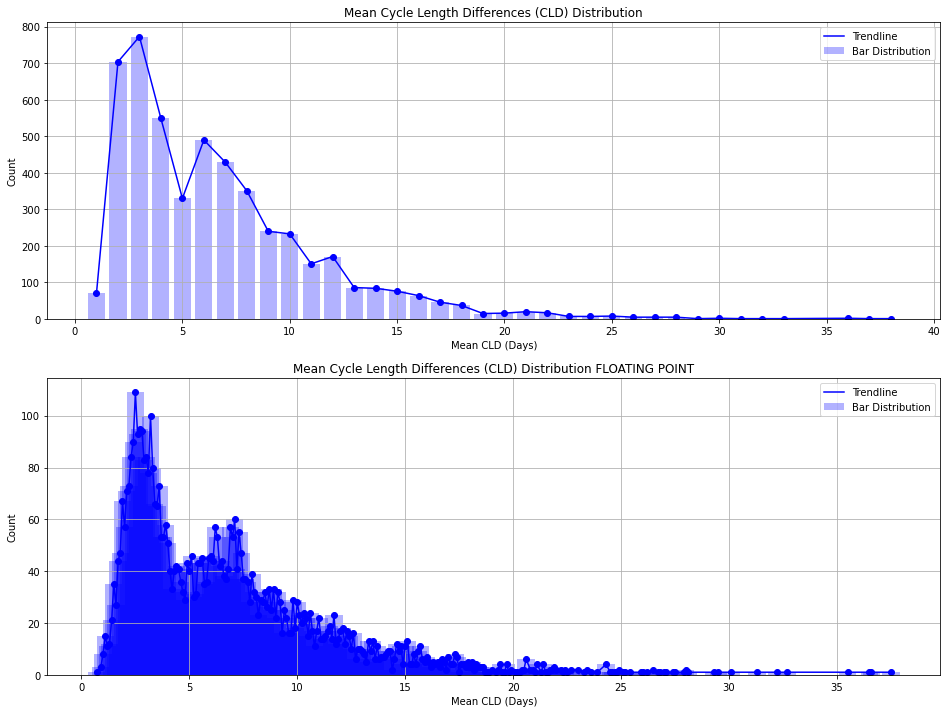

In [ ]:
# calculate mean cycle length differences (CLD)
# CLD is the absolute difference between subsequent cycles and a measure of menstrual variablility
cld = []
mean_cld = []
mean_cld_FLOAT = []
            
for i in range(len(cycle_len)):
    pts = []
    for j in range(len(cycle_len[i])):
        if j == 0:
            continue
        else:
            pts.append(abs(cycle_len[i][j] - cycle_len[i][j-1]))
    cld.append(pts)       
            
print("CLD 2D Array:", type(cld), len(cld), cld[0:20])

# create a list for average CLD of all 5000 patients
for i in range(len(cld)):
#     mean_cld.append(mean(cld[i][:])) # returns int type
    mean_cld.append(round(sum(cld[i][:]) / len(cld[i][:]))) # returns int type
    mean_cld_FLOAT.append(sum(cld[i][:]) / len(cld[i][:])) # return float type

print('Mean CLD 1D Array:', type(mean_cld), len(mean_cld), mean_cld[0:20])
    
# calculate probability of CLD
mean_cld_sorted = sorted(mean_cld) # sort list
mean_cld_FLOAT_sorted = sorted(mean_cld_FLOAT) # sort list
# print('Mean CLD 1D Array SORTED:', mean_cld_sorted[0:20])
mean_cld_vals = numpy.unique(mean_cld_sorted, return_counts=True)[0]
mean_cld_prob = numpy.unique(mean_cld_sorted, return_counts=True)[1]

mean_cld_vals_FLOAT = numpy.unique(mean_cld_FLOAT_sorted, return_counts=True)[0]
mean_cld_prob_FLOAT = numpy.unique(mean_cld_FLOAT_sorted, return_counts=True)[1]
# print(len(mean_cld_vals), mean_cld_vals)
# print(len(mean_cld_prob), mean_cld_prob)

# plot mean CLD distribution
x = mean_cld_vals
y = mean_cld_prob
x2 = mean_cld_vals_FLOAT
y2 = mean_cld_prob_FLOAT

fig = plt.figure(figsize=(16,12))
axes = fig.add_subplot(2, 1, 1)
axes.bar(x, y, color='b', alpha=.3, label='Bar Distribution')
axes.plot(x, y, 'b', label='Trendline')
axes.plot(x, y, 'bo')
axes.set_title("Mean Cycle Length Differences (CLD) Distribution")
axes.set_xlabel("Mean CLD (Days)")
axes.set_ylabel("Count")
axes.grid()
plt.legend()

axes = fig.add_subplot(2, 1, 2)
axes.bar(x2, y2, color='b', alpha=.3, label='Bar Distribution')
axes.plot(x2, y2, 'b', label='Trendline')
axes.plot(x2, y2, 'bo')
axes.set_title("Mean Cycle Length Differences (CLD) Distribution FLOATING POINT")
axes.set_xlabel("Mean CLD (Days)")
axes.set_ylabel("Count")
axes.grid()
plt.legend()

plt.show()

#### Visually Investigate the Correlation Between Skipped Cycles and Cycle Variability

In [ ]:
# calculate mean CLD
print('Mean CLD List:', len(mean_cld), mean_cld[0:30])
print('Mean CLD List FLOATING POINT:', len(mean_cld_FLOAT), mean_cld_FLOAT[0:30])

Mean CLD List: 5000 [3, 3, 11, 4, 15, 2, 9, 2, 5, 15, 17, 5, 3, 8, 2, 14, 9, 2, 4, 4, 6, 7, 7, 11, 5, 3, 11, 6, 6, 3]
Mean CLD List FLOATING POINT: 5000 [2.8, 3.3, 11.1, 4.5, 14.9, 1.8, 8.7, 1.6, 4.9, 14.7, 17.4, 5.4, 3.2, 8.4, 1.8, 14.0, 9.2, 2.5, 3.6, 4.4, 6.4, 7.3, 6.9, 10.6, 5.3, 3.1, 11.0, 6.1, 5.7, 3.4]


Skipped Cycles Array: [[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 2 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 1 0 0 0 1 0]]
Total Skipped Cycles List: 5000 [0, 0, 2, 0, 5, 0, 2, 0, 1, 4]
13 [ 0  1  2  3  4  5  6  7  8  9 11 12 14]
13 [2074 1406  784  377  189   89   37   19   14    7    2    1    1]


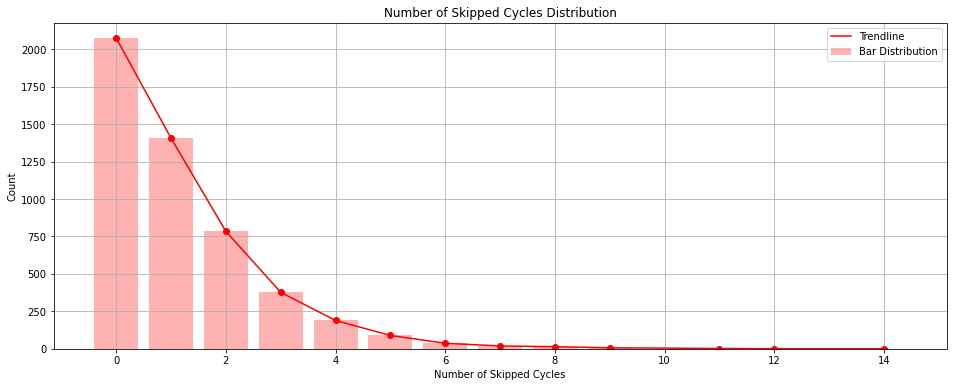

In [ ]:
# create skipped cycles list
print('Skipped Cycles Array:', cycle_skip[:10])

total_skip = []
for i in range(len(cycle_skip)):
    total_skip.append(sum(cycle_skip[i]))
    
print('Total Skipped Cycles List:', len(total_skip), total_skip[0:10])

# plot distribution of skipped cycles
total_skip_sorted = sorted(total_skip)
# print('Total Skipped Cycles List SORTED:', total_skip_sorted[0:10])
total_skip_vals = numpy.unique(total_skip_sorted, return_counts=True)[0]
total_skip_prob = numpy.unique(total_skip_sorted, return_counts=True)[1]
print(len(total_skip_vals), total_skip_vals)
print(len(total_skip_prob), total_skip_prob)

x = total_skip_vals
y = total_skip_prob

fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 1, 1)
axes.bar(x, y, color='r', alpha=.3, label='Bar Distribution')
axes.plot(x, y, 'r', label='Trendline')
axes.plot(x, y, 'ro')
axes.set_title("Number of Skipped Cycles Distribution")
axes.set_xlabel("Number of Skipped Cycles")
axes.set_ylabel("Count")
axes.grid()

plt.legend()
plt.show()

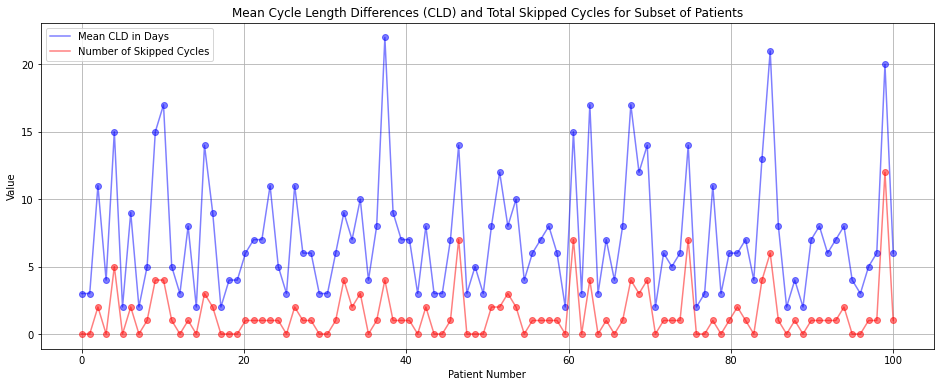

In [ ]:
# plot average CLD and Total Skipped Cycles for Patient Subset
N = 100 # number of patients plotted
x = numpy.linspace(0, N, N)
# x = numpy.linspace(0, len(mean_cld), len(mean_cld))
y1 = mean_cld[0:N]
y2 = total_skip[0:N]

fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 1, 1)
# axes.bar(x, y, color='b', alpha=.3, label='Bar Distribution')
# axes.plot(x, y, 'b', label='Trendline')
axes.plot(x, y1, 'b', alpha=0.5, label='Mean CLD in Days')
axes.plot(x, y1, 'ob', alpha=0.5)
axes.plot(x, y2, 'r', alpha=0.5, label='Number of Skipped Cycles')
axes.plot(x, y2, 'or', alpha=0.5)
axes.set_title("Mean Cycle Length Differences (CLD) and Total Skipped Cycles for Subset of Patients")
axes.set_xlabel("Patient Number")
axes.set_ylabel("Value")
axes.grid()
plt.legend()

plt.show()

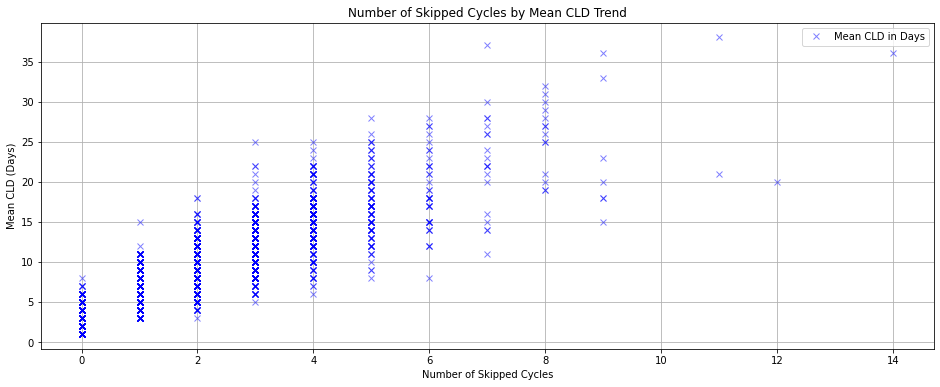

In [ ]:
# plot mean CLD (y) to number of skipped periods (x)
x = total_skip
y = mean_cld

fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, y, 'xb', alpha=0.5, label='Mean CLD in Days')
axes.set_title("Number of Skipped Cycles by Mean CLD Trend")
axes.set_xlabel("Number of Skipped Cycles")
axes.set_ylabel("Mean CLD (Days)")
axes.grid()
plt.legend()

plt.show()

#### Investiate the Correlation between Skipped Cycles and Menstrual Variability using Classic Statistics

In [ ]:
# calculate correlation between mean CLD and number of skipped cycles

# pearson's correlation
corr, _ = pearsonr(mean_cld, total_skip)
print('Pearsons correlation: %.3f' % corr)

# spearman's correlation
corr, _ = spearmanr(mean_cld, total_skip)
print('Spearmans correlation: %.3f' % corr)

Pearsons correlation: 0.898
Spearmans correlation: 0.910


#### Implement Poisson Regression Model to Investigate the Effect of Skipped Cycles on Menstrual Variability

In [ ]:
# create dataframe from list data
df = pd.DataFrame(list(zip(mean_cld, total_skip)), columns =['mean_cld', 'total_skip'])
df

,mean_cld,total_skip
0,3,0
1,3,0
2,11,2
3,4,0
4,15,5
...,...,...
4995,3,0
4996,7,1
4997,2,0
4998,5,1


In [ ]:
# create test and training sets
mask = np.random.rand(len(df)) < 0.9
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

# let mean cld be dependent on number of skipped cycles
expr = """mean_cld ~ total_skip""" 
# expr = """total_skip ~ mean_cld""" 

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

Training data set length=4500
Testing data set length=500


In [ ]:
# train the model
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
poisson_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               mean_cld   No. Observations:                 4500
Model:                            GLM   Df Residuals:                     4498
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10115.
Date:                Thu, 23 Dec 2021   Deviance:                       4261.6
Time:                        20:54:32   Pearson chi2:                 4.06e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4749      0.008    190.274      0.000       1.460       1.490
total_skip     0.2685      0.002    108.834      0.000       0.264       0.273
==============================================================================
"""

In [ ]:
# make predictions using the model
poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
predictions_summary_frame

,mean,mean_se,mean_ci_lower,mean_ci_upper
0,4.370605,0.033879,4.304706,4.437513
5,4.370605,0.033879,4.304706,4.437513
13,5.716988,0.036462,5.645969,5.788900
19,4.370605,0.033879,4.304706,4.437513
23,5.716988,0.036462,5.645969,5.788900
...,...,...,...,...
4906,4.370605,0.033879,4.304706,4.437513
4912,5.716988,0.036462,5.645969,5.788900
4926,4.370605,0.033879,4.304706,4.437513
4956,7.478129,0.043247,7.393846,7.563373


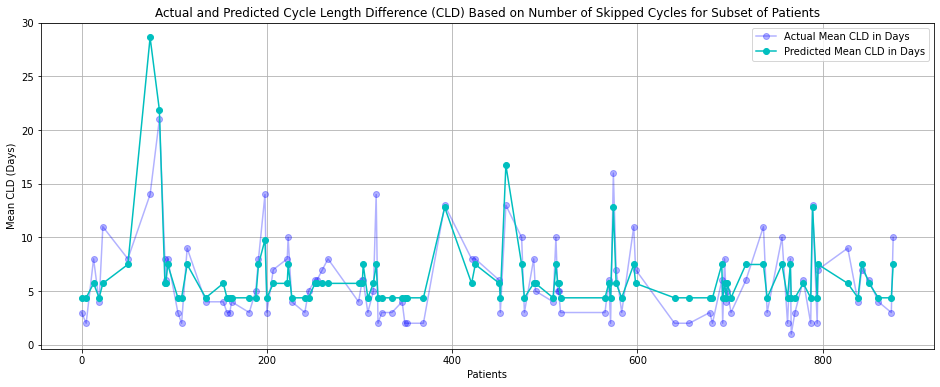

In [ ]:
# plot predicted and real data CLD data
N = 100 # number of plotted datapoints
predicted=predictions_summary_frame['mean']
actual = y_test['mean_cld']

fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 1, 1)
actual, = plt.plot(X_test.index[:N], actual[:N], 'bo-', alpha=.3, label='Actual Mean CLD in Days')
predicted, = axes.plot(X_test.index[:N], predicted[:N], 'co-', alpha=1., label='Predicted Mean CLD in Days')

axes.set_title("Actual and Predicted Cycle Length Difference (CLD) Based on Number of Skipped Cycles for Subset of Patients")
axes.set_xlabel("Patients")
axes.set_ylabel("Mean CLD (Days)")
axes.grid()
plt.legend()

plt.show()

#### Test Regression Model's Goodness-of-Fit

In [ ]:
# test cell goodness of fit regression model using Chi-Squared
chi_expected = 500.456 # retrieved from standardized table based on model's DF Residuals = 4464 and p = 0.05
chi_model = 4080 # retrieved from poisson_training_results.summary()

if chi_model <= chi_expected:
    print('success! The model fit is sufficient!')
elif chi_model > chi_expected:
    print('chi-squared value of the model is larger than expected value, the model fit is insufficient')

chi-squared value of the model is larger than expected value, the model fit is insufficient


In [ ]:
# # test cell goodness of fit regression model
# # commented out to avoid AssertionError in code submission
# numpy.testing.assert_array_less(
#                         chi_model, chi_expected, 
#                         err_msg='chi-squared value of the model is larger than expected value, the model fit is insufficient', 
#                         verbose=True)

# Discussion


To assess the effect of skipping menstrual cycles on the cycle length variability and subsquently the accuracy in predicting a fertility window, a Poisson regression model has been applied to a subset of data including cycle length and number of skipped cycles. Initial data exploration visually suggests a strong correlation between number of skipped cycles and cycle variability which was confirmed by the use of classic statistical correlation methods (Pearson's = 0.898 , Spearman's = 0.910). Further, while visual evaluation of the prediction model shows high similarity between predicted and real CLD values, accuracy analysis of the regression model showed insuffient fit to provide cycle length variability prediction solely using skipped cycle data. 

The raw data set contained 5000 user entries with 11 cycles lengths and corresponding number of skipped cycles. Initial data exploration was performed to show distribution of mean cycle length and mean cycle length difference (CLD). It is to be noted that for both metrics, results were rounded to the nearest integer of days. For CLD, plots for both the rounded and floating point analysis are presented. Rounding might have introduced some degree of type I error which should be taken into account when interpreting the results. 

Further, the correlation between skipped cycles and CLD was visually interpreted. There appears to be an exponential correlation between number of skips and average CLD, which suggests a potential effect of skiping cycles on CLD. This was expected as skipping a cycle will inherently increase the length of the preceeding cycle by another full cycle length. In this initial analysis, this potential analysis error is noted but not accounted for. In future research, double cycle length due to skipped cycles could be divided by 2 to create a more insightful representation of the skipping effect on CLD. When looking at the conjuctial tracing of skipped cycles and CLD per user, a correlation can be observed as peaks correlate. Furter, plotting all datapoints on a graph with number of skipped cycles on the x-axis and CLD on the y-axis illustrated a linear positive trend as number of skipped cycles increases. Subsequent statistial analysis showed a strong positive correlation between the two parameters with a Pearsons correlation of 0.898 and a Spearmans correlation: 0.910.

Finally, a Poisson regression model was implemented to evaluate the efficacy in predicting CLD using solely skipped cycle data. The dataset with 5000 entries was split into a train and test set of 90% and 10%, respectively. Prediction accuracy was evaluated visaully by plotting predictions and real values in one graph and analytically using the degrees of freedom (DF) residuals and chi-squared test. Running the model with a 90/10 split resulted in comparable DF residuals and chi-squared values. One particular run resulted in a DF residuals of 4464, which corresponds to an expected chi-squared value of 500.456 assuming a 95% confidence interval. Any real chi-squared value lower than the expected value would indicate a good model fit. Any real value higher than the expected would indicate poor fit of the model to the data. My resulting chi-squared value for this particular run was 4080, which is significantl higher than expected and indicates poor fit. This poor fit might be due to a variety of reasons such as underfitting due to the small dataset size. Future studies including more data might yield better prediction results. 

In conclusion, this research has showed initial correlation between number of skipped menstrual cycles and cylce variability. The effect of the first parameter on the second was investigated using Poisson regression. However, the model did not fit the data well enough to provide reliable predictions, likely due to the small dataset size. Neverteless, this research has emphasized the importance of critically evaluating real-world user metrics, such as skipping menstrual cycles, to further inform the clinical prediction accuracy of fertility trackers.